In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from PIL import Image as pil_image

In [2]:
def img_show(np_img, grayscale = False):
    res = pil_image.fromarray(np_img.astype(np.uint8))
    if grayscale:
        return res.convert('LA')
    return res

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

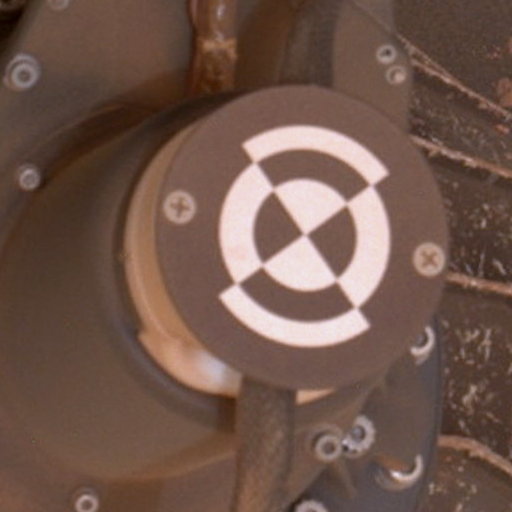

In [3]:
image = pil_image.open('./imgs/marker_cut_rgb_512.png')
np_img = np.array(image)
grayscaled = rgb2gray(np_img)
image

# Utilities

In [4]:
class HammingDistance():
    
    @staticmethod
    def compute(arr_1, arr_2):
        if len(arr_1) != len(arr_2):
            return "length not equal"
        count = 0
        for (i, el) in enumerate(arr_1):
            if el != arr_2[i]:
                count += 1
        return count

In [5]:
class Convolution():
    
    @staticmethod
    def create_padding(img, kernel):
        (iW, iH) = img.shape
        (kW, kH) = kernel.shape
        
        paddings = (
            (((iH + kH*2) // kH * kH) - iH) // 2, 
            (((iW + kW*2) // kW * kW) - iH) // 2,
        )
        return np.pad(img, (paddings, paddings), 'constant', constant_values=0)
     
        
    def __convolve(img, kernel):
        (iH, iW) = img.shape
        (kH, kW) = kernel.shape
        
        img_with_padding = Convolution.create_padding(img, kernel)
        
        result = np.zeros(img.shape)
        
        for x in range(iW):
            for y in range(iH):
                roi = img_with_padding[x:x + kW, y:y + kH]
                k = np.multiply(kernel, roi)
                result[x, y] = k.sum(axis=(0, 1))
                
        return result
    
    
    @staticmethod
    def run(img, kernel):
        return Convolution.__convolve(img, kernel)

In [6]:
class GaussianBlur():
    def __make_gaussian(size, sigma):
        x = np.arange(size)
        y = x[:,np.newaxis]
        x0 = y0 = size // 2
        result = np.exp(-((x - x0) ** 2 + (y - y0) ** 2) / (2 * sigma ** 2)) / (2 * np.pi * sigma ** 2)
        return result / result.sum()
    
    @staticmethod
    def run(img, shape, sigma):
        kernel = GaussianBlur.__make_gaussian(shape, sigma)
        return Convolution.run(img, kernel)

In [7]:
class NonMaximumSupression():
    
    @staticmethod
    def run(img, shape):
        (iW, iH) = img.shape
        img_with_padding = Convolution.create_padding(img, np.zeros((shape, shape)))
        result = np.zeros(img.shape)
        for i in range(iW):
            for j in range(iH):
                max_score = img_with_padding[i : i + shape, j : j + shape].max()
                if max_score and max_score == img[i, j]:
                    result[i, j] = 1
        return result

# FAST. Fast corner detection

In [8]:
class Fast():
    def __create_circle(img, x, y):
        radius = 3
        return np.array([
            img[x, y - radius],  # p1
            img[x + 1, y - radius],
            img[x + 2, y - 2],
            img[x + radius, y - 1],
            img[x + radius, y],  # p5
            img[x + radius, y + 1],
            img[x + 2, y + 2],
            img[x + 1, y + radius],
            img[x, y + radius],  # p9
            img[x - 1, y + radius],
            img[x - 2, y + 2],
            img[x - radius, y + 1],
            img[x - radius, y],  # 13
            img[x - radius, y - 1],
            img[x - 2, y - 2],
            img[x - 1, y - radius],
        ])
    
    
    def __count_subsiquent_points_by_condition(circle, fn):
        matched_indexes = fn(circle)[0]
        if len(matched_indexes) < 12:
            return 0
        
        count = 0
        prev_index = matched_indexes[0]
        for index in matched_indexes:
            if prev_index + 1 == index:
                count += 1
            else:
                count = 0
            prev_index = index
        return count
    
    def __high_speed_test(img, x, y, radius, thre):   
        p = img[x, y]
        pts = np.array([img[x, y - radius], img[x, y + radius], img[x + radius, y], img[x - radius, y]])

        l = p - thre
        h = p + thre
        
        brighter = pts[pts > h]
        if brighter.shape[0] >= 3:
            return True, "B"

        darker = pts[pts < l]
        if darker.shape[0] >= 3:
            return True, "D"

        return False, ""
    
    
    def __find_key_points(img, thre):
        (iH, iW) = img.shape
        radius = 3
        corners = np.zeros(img.shape)
        
        for x in range(radius, iW - radius):
            for y in range(radius, iH - radius):
                passed, condition = Fast.__high_speed_test(img, x, y, radius, thre)
                if not passed:
                    continue
                    
                pt = img[x, y]
                circle = Fast.__create_circle(img, x, y)
                
                if condition == 'B':  
                    count = Fast.__count_subsiquent_points_by_condition(circle, lambda pts: np.where(pts > pt - thre))
                else:
                    count = Fast.__count_subsiquent_points_by_condition(circle, lambda pts: np.where(pts < pt + thre))
                
                corners[x, y] = count
                
        return corners
    
    @staticmethod
    def run(img, thre):
        img_blur = GaussianBlur.run(img, 3, 3)
        key_points = Fast.__find_key_points(img_blur, thre)
        key_points = NonMaximumSupression.run(key_points, 5)
        return key_points

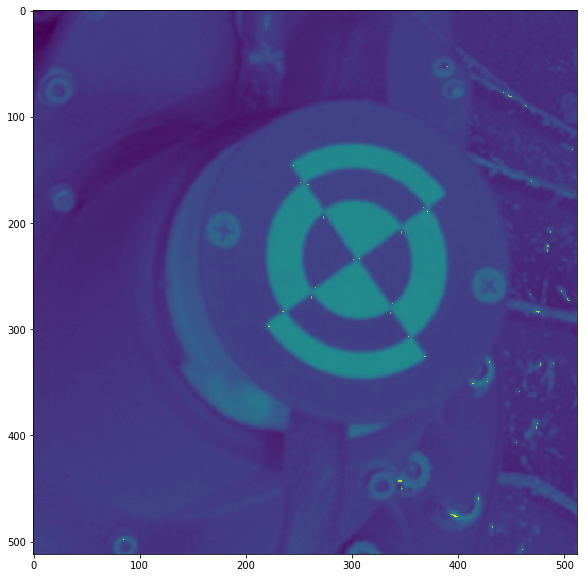

In [9]:
key_points = Fast.run(grayscaled, 25)
    
ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(10, 10)
ax.imshow(grayscaled + 255 * key_points / key_points.max())

# BRIEF. Binary Robust Independent Elementary Features 

In [10]:
class Brief():
    def __generate_fingerprint(img, x, y, size, length):
        np.random.seed(0)

        half = size // 2
        (iW, iH) = img.shape[:2]

        store = set()
        while len(store) < length:
            px = np.random.randint(x - half, x + half)
            py = np.random.randint(y - half, y + half)
            if (px != x and py != y) and \
               (0 < px < iW) and \
               (0 < py < iH):
                store.add((px, py))

        result = []
        for (x, y) in store:
            if x < y:
                result.append(1)
            else:
                result.append(0)
        result = [str(i) for i in result] 
        return ''.join(result)
    
    def __compute_descriptors(img, kp_arr, size, fingerprint_length):
        result = []
        for (x, y) in kp_arr:
            fp = Brief.__generate_fingerprint(img, x, y, size, fingerprint_length)
            result.append(fp)
        return result
    
    @staticmethod
    def run(img, kp, size, l):
        return Brief.__compute_descriptors(img, kp, size, l)

# Example

In [11]:
def display_row(imgs, size):
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(size, size)
    ax.imshow(np.hstack(imgs))

def get_kp_coordinates(kp):
    result = list(zip(*np.where(kp > 0)))
    return result

def compute_hamming_distances(discr_1, discr_2):
    result = []
    for d1 in discr_1:
        distances = [HammingDistance.compute(d1, d2) for d2 in discr_2]
        result.append(np.argmin(distances))
    return result
        
def map_descr_indexes_to_key_points(kp1, descr_indexes, kp_2):
    result = []
    for i, (x1, y1) in enumerate(kp1):
        (x2, y2) = kp_2[descr_indexes[i]]
        result.append([(x1, y1), (x2, y2)])
    return result

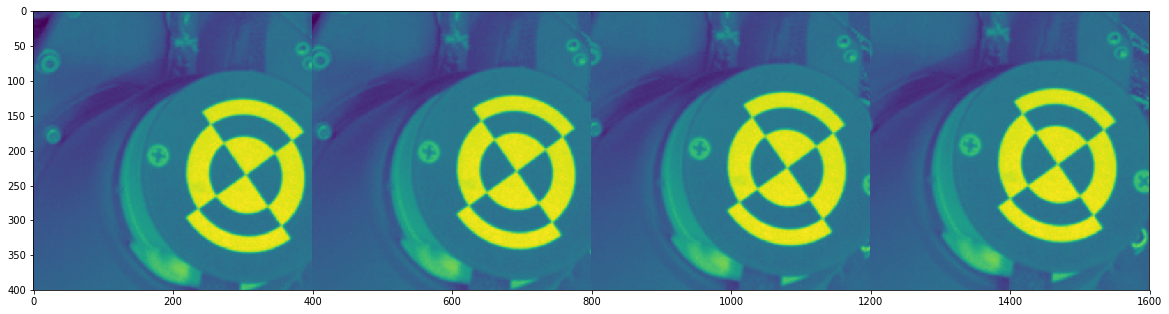

In [12]:
img_1 = np.array(pil_image.open('./imgs/translation_0.png'))
img_2 = np.array(pil_image.open('./imgs/translation_1.png'))
img_3 = np.array(pil_image.open('./imgs/translation_2.png'))
img_4 = np.array(pil_image.open('./imgs/translation_3.png'))

display_row((img_1, img_2, img_3, img_4), 20)

In [13]:
key_points_1 = Fast.run(img_1, 12)
key_points_2 = Fast.run(img_2, 12)
key_points_3 = Fast.run(img_3, 15)
key_points_4 = Fast.run(img_4, 15)

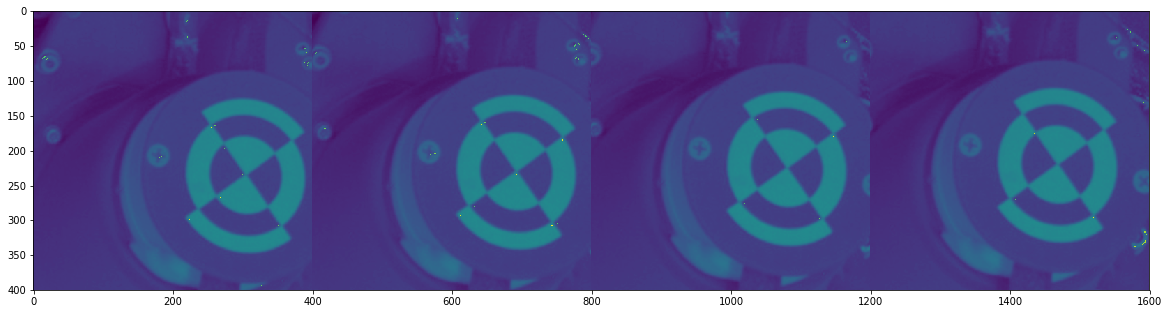

In [14]:
display_row(
    (
        img_1 + 255 * key_points_1 / key_points_1.max(),
        img_2 + 255 * key_points_2 / key_points_2.max(),
        img_3 + 255 * key_points_3 / key_points_3.max(),
        img_4 + 255 * key_points_4 / key_points_4.max(),
    ),
    20
)

In [15]:
kp_coordinates_1 = get_kp_coordinates(key_points_1)
kp_coordinates_2 = get_kp_coordinates(key_points_2)
kp_coordinates_3 = get_kp_coordinates(key_points_3)
kp_coordinates_4 = get_kp_coordinates(key_points_4)

In [16]:
descriptors_1 = Brief.run(img_1, kp_coordinates_1, 99, 512)
descriptors_2 = Brief.run(img_2, kp_coordinates_2, 99, 512)
descriptors_3 = Brief.run(img_3, kp_coordinates_3, 99, 512)
descriptors_4 = Brief.run(img_4, kp_coordinates_4, 99, 512)

In [17]:
indexes_of_best_kp_from_descr_2 = compute_hamming_distances(descriptors_1, descriptors_2)
indexes_of_best_kp_from_descr_3 = compute_hamming_distances(descriptors_2, descriptors_3)
indexes_of_best_kp_from_descr_4 = compute_hamming_distances(descriptors_3, descriptors_4)

In [18]:
links1 = map_descr_indexes_to_key_points(kp_coordinates_1, indexes_of_best_kp_from_descr_2, kp_coordinates_2)
links2 = map_descr_indexes_to_key_points(kp_coordinates_2, indexes_of_best_kp_from_descr_3, kp_coordinates_3)
links3 = map_descr_indexes_to_key_points(kp_coordinates_3, indexes_of_best_kp_from_descr_4, kp_coordinates_4)

In [19]:
def draw_links(img, offset_1, offset_2, links):
    for [kp_0, kp_1] in links:
        x_0 = kp_0[0]
        y_0 = kp_0[1] + offset_1
        cv2.circle(img, (y_0, x_0), 5, (0, 0, 255))
        x_1 = kp_0[0]
        y_1 = kp_0[1] + offset_2
        cv2.circle(img, (y_1, x_1), 5, (0, 0, 255))
        cv2.line(img, (y_0, x_0), (y_1, x_1), (255, 0, 0))
    return img

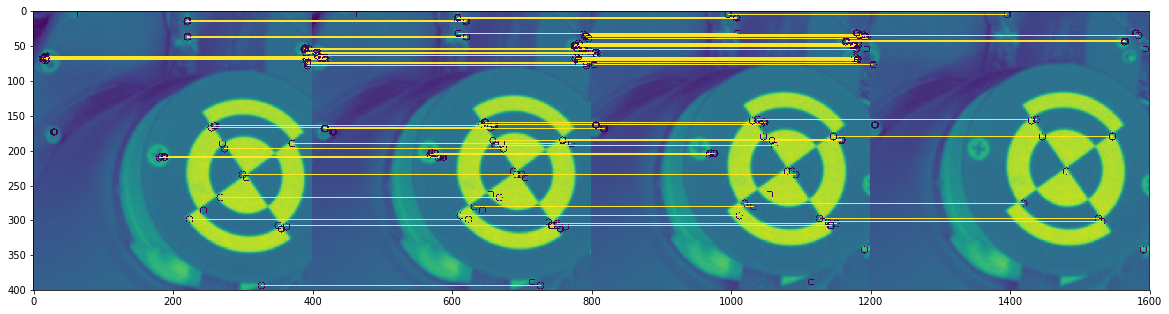

In [20]:
(rows, cols) = img_1.shape

final = np.zeros((rows, cols*4), np.uint8)
final[:, 0:cols] = img_1 + 255 * key_points_1 / key_points_1.max()
final[:, cols:cols*2] = img_2 + 255 * key_points_2 / key_points_2.max()
final[:, cols*2:cols*3] = img_3
final[:, cols*3:cols*4] = img_3
final_bgr = cv2.cvtColor(final, cv2.COLOR_GRAY2BGR)

final_bgr = draw_links(final, 0, cols, links1)
final_bgr = draw_links(final, cols, cols*2, links2)
final_bgr = draw_links(final, cols*2, cols*3, links3)

ax = plt.gca()
fig = plt.gcf()

fig.set_size_inches(20, 20)
ax.imshow(final_bgr)